
# 03 · Modelado no supervisado (clustering)

Objetivo: entrenar y comparar modelos de clustering sobre el dataset preprocesado, seleccionar la configuración más representativa y analizar el perfil de personalidad (Big Five) de los grupos detectados.


In [1]:

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
    adjusted_rand_score,
)

sns.set_theme(style='whitegrid', context='notebook')
RANDOM_STATE = 42


## 1) Dataset final de entrada

In [2]:

X = pd.read_csv('../data/processed/handwriting_personality_clustering_input.csv')
profiles = pd.read_csv('../data/processed/handwriting_personality_profile_targets.csv')

print(f'Tamaño de X: {X.shape}')
print(f'Tamaño de perfiles Big Five: {profiles.shape}')
X.head()


Tamaño de X: (2000, 20)
Tamaño de perfiles Big Five: (2000, 5)


,num__Writing_Speed_wpm,num__Age,num__Feature_1,num__Feature_2,num__Feature_3,num__Feature_4,num__Feature_5,num__Feature_6,num__Feature_7,num__Feature_8,num__Feature_9,num__Feature_10,num__Feature_11,num__Feature_12,num__Feature_13,num__Feature_14,num__Feature_15,cat__Gender_Female,cat__Gender_Male,cat__Gender_Other
0,1.699998,0.498818,-1.245883,-0.709052,-0.757852,0.384588,1.731094,1.685432,0.858962,1.496029,-1.592864,-0.793286,1.135773,-0.632607,-1.072436,-0.891973,-0.421163,0.0,1.0,0.0
1,-0.196414,-0.219653,1.040399,0.196265,-0.165196,0.995579,0.223452,1.367472,-1.320924,-0.063791,-1.651003,-0.240554,1.401398,-0.966704,0.489943,0.246159,0.557358,0.0,1.0,0.0
2,-1.686452,-0.379313,-0.179244,-0.178490,1.136932,0.330972,-0.064508,1.531019,1.566699,-0.058489,-0.766341,1.279789,0.215561,-1.018803,0.098608,-0.605381,-0.430187,0.0,0.0,1.0
3,-1.550994,-1.017954,1.144247,-0.746141,0.812933,1.011973,1.577624,1.149833,-0.965702,-0.533650,-0.115934,1.259614,-0.716594,-0.527056,0.283031,1.058205,-1.263869,0.0,1.0,0.0
4,-1.618723,1.456780,1.475419,1.258237,1.474178,0.923341,0.073275,1.033863,-1.072292,-1.378117,-0.689579,-0.730022,-0.485231,-1.001038,0.739819,-1.576820,-1.666780,0.0,0.0,1.0


## 2) Baseline K-Means y selección de k

In [3]:

k_values = range(2, 9)
rows = []

for k in k_values:
    model = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=20)
    labels = model.fit_predict(X)
    rows.append(
        {
            'model': 'KMeans',
            'k': k,
            'silhouette': silhouette_score(X, labels),
            'davies_bouldin': davies_bouldin_score(X, labels),
            'calinski_harabasz': calinski_harabasz_score(X, labels),
            'inertia': model.inertia_,
        }
    )

kmeans_metrics = pd.DataFrame(rows)
kmeans_metrics


,model,k,silhouette,davies_bouldin,calinski_harabasz,inertia
0,KMeans,2,0.044124,4.584771,93.970784,33745.632105
1,KMeans,3,0.038172,4.076568,79.752677,32719.391839
2,KMeans,4,0.039667,3.761434,73.196906,31830.883912
3,KMeans,5,0.038702,3.538028,66.137049,31196.005561
4,KMeans,6,0.038879,3.393972,61.345110,30622.316266
5,KMeans,7,0.039026,3.273684,57.300370,30134.434165
6,KMeans,8,0.039983,3.158349,54.404485,29661.980998


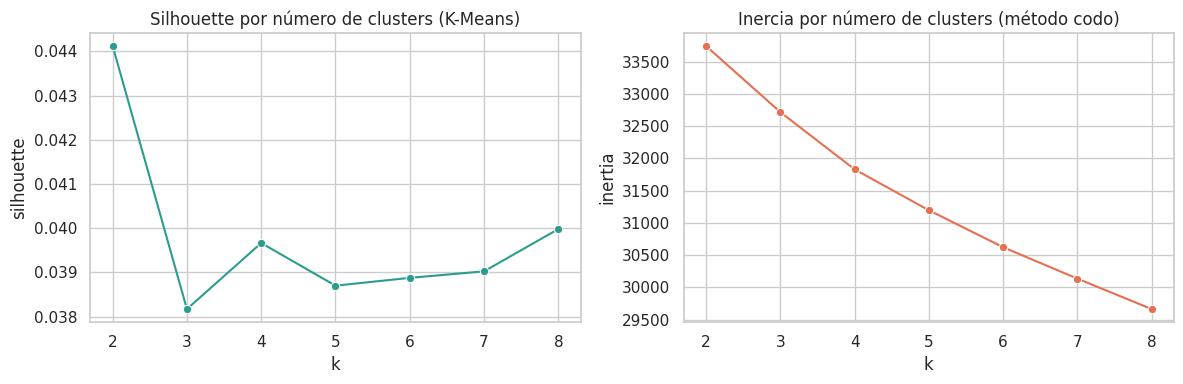

In [4]:

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.lineplot(data=kmeans_metrics, x='k', y='silhouette', marker='o', ax=axes[0], color='#2a9d8f')
axes[0].set_title('Silhouette por número de clusters (K-Means)')

sns.lineplot(data=kmeans_metrics, x='k', y='inertia', marker='o', ax=axes[1], color='#e76f51')
axes[1].set_title('Inercia por número de clusters (método codo)')

plt.tight_layout()
plt.show()


## 3) Comparación con otros algoritmos (Agglomerative + DBSCAN)

In [5]:

benchmark_rows = []

# K-Means con mejor silhouette
best_k = int(kmeans_metrics.sort_values('silhouette', ascending=False).iloc[0]['k'])
km_best = KMeans(n_clusters=best_k, random_state=RANDOM_STATE, n_init=20)
km_labels = km_best.fit_predict(X)
benchmark_rows.append({
    'algorithm': f'KMeans(k={best_k})',
    'n_clusters': len(np.unique(km_labels)),
    'silhouette': silhouette_score(X, km_labels),
    'davies_bouldin': davies_bouldin_score(X, km_labels),
    'calinski_harabasz': calinski_harabasz_score(X, km_labels),
    'noise_ratio': 0.0,
})

# Agglomerative para el mismo k
agg = AgglomerativeClustering(n_clusters=best_k, linkage='ward')
agg_labels = agg.fit_predict(X)
benchmark_rows.append({
    'algorithm': f'Agglomerative(k={best_k})',
    'n_clusters': len(np.unique(agg_labels)),
    'silhouette': silhouette_score(X, agg_labels),
    'davies_bouldin': davies_bouldin_score(X, agg_labels),
    'calinski_harabasz': calinski_harabasz_score(X, agg_labels),
    'noise_ratio': 0.0,
})

# DBSCAN con búsqueda ligera de eps
for eps in [1.5, 2.0, 2.5, 3.0]:
    db = DBSCAN(eps=eps, min_samples=10)
    db_labels = db.fit_predict(X)
    n_clusters = len(set(db_labels)) - (1 if -1 in db_labels else 0)
    noise_ratio = float((db_labels == -1).mean())

    if n_clusters >= 2:
        mask = db_labels != -1
        benchmark_rows.append({
            'algorithm': f'DBSCAN(eps={eps})',
            'n_clusters': n_clusters,
            'silhouette': silhouette_score(X[mask], db_labels[mask]),
            'davies_bouldin': davies_bouldin_score(X[mask], db_labels[mask]),
            'calinski_harabasz': calinski_harabasz_score(X[mask], db_labels[mask]),
            'noise_ratio': noise_ratio,
        })
    else:
        benchmark_rows.append({
            'algorithm': f'DBSCAN(eps={eps})',
            'n_clusters': n_clusters,
            'silhouette': np.nan,
            'davies_bouldin': np.nan,
            'calinski_harabasz': np.nan,
            'noise_ratio': noise_ratio,
        })

benchmark = pd.DataFrame(benchmark_rows)
benchmark


,algorithm,n_clusters,silhouette,davies_bouldin,calinski_harabasz,noise_ratio
0,KMeans(k=2),2,0.044124,4.584771,93.970784,0.0
1,Agglomerative(k=2),2,0.019045,6.377974,40.335006,0.0
2,DBSCAN(eps=1.5),0,NaN,NaN,NaN,1.0
3,DBSCAN(eps=2.0),0,NaN,NaN,NaN,1.0
4,DBSCAN(eps=2.5),0,NaN,NaN,NaN,1.0
5,DBSCAN(eps=3.0),0,NaN,NaN,NaN,1.0


## 4) Modelo seleccionado y composición de clusters

In [6]:

selected_k = best_k
selected_model = KMeans(n_clusters=selected_k, random_state=RANDOM_STATE, n_init=20)
cluster_labels = selected_model.fit_predict(X)

clustered = X.copy()
clustered['cluster'] = cluster_labels
profile_cluster = profiles.copy()
profile_cluster['cluster'] = cluster_labels

cluster_sizes = clustered['cluster'].value_counts().sort_index().rename('n')
cluster_sizes


cluster
0     989
1    1011
Name: n, dtype: int64

In [7]:

bigfive_by_cluster = profile_cluster.groupby('cluster').mean().round(3)
bigfive_by_cluster


,Openness,Conscientiousness,Extraversion,Agreeableness,Neuroticism
cluster,,,,,
0,0.510,0.502,0.477,0.493,0.485
1,0.497,0.503,0.509,0.489,0.522


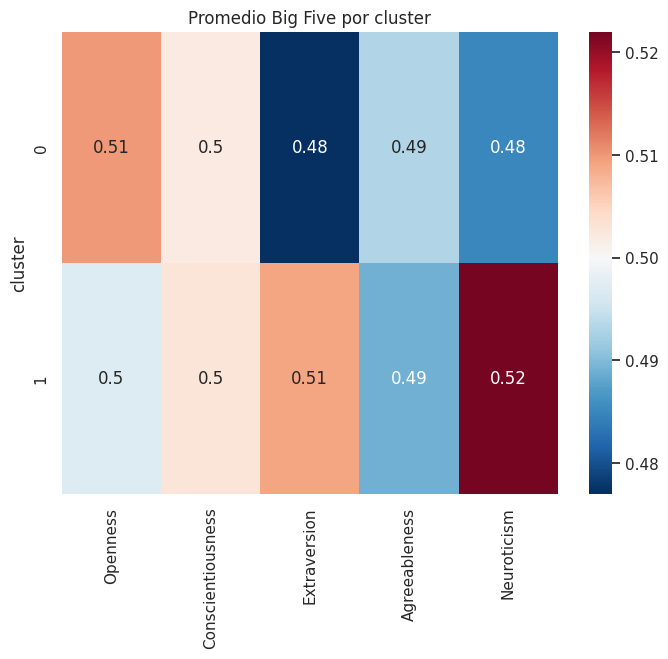

In [8]:

feature_centroids = clustered.groupby('cluster').mean().T

plt.figure(figsize=(8, 6))
sns.heatmap(bigfive_by_cluster, annot=True, cmap='RdBu_r', center=0.5)
plt.title('Promedio Big Five por cluster')
plt.show()


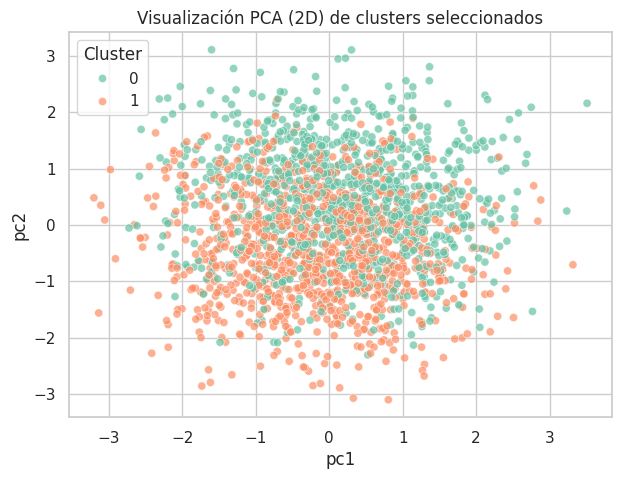

In [9]:

pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X)

plot_df = pd.DataFrame({'pc1': X_pca[:, 0], 'pc2': X_pca[:, 1], 'cluster': cluster_labels})

plt.figure(figsize=(7, 5))
sns.scatterplot(data=plot_df, x='pc1', y='pc2', hue='cluster', palette='Set2', alpha=0.7, s=35)
plt.title('Visualización PCA (2D) de clusters seleccionados')
plt.legend(title='Cluster')
plt.show()


## 5) Estabilidad básica (K-Means con múltiples semillas)

In [10]:

seeds = [7, 21, 42, 99, 2024]
label_runs = {
    seed: KMeans(n_clusters=selected_k, random_state=seed, n_init=20).fit_predict(X)
    for seed in seeds
}

pairs = []
for i, s1 in enumerate(seeds):
    for s2 in seeds[i + 1:]:
        ari = adjusted_rand_score(label_runs[s1], label_runs[s2])
        pairs.append({'seed_1': s1, 'seed_2': s2, 'ari': ari})

stability = pd.DataFrame(pairs)
stability


,seed_1,seed_2,ari
0,7,21,0.898653
1,7,42,0.000029
2,7,99,-0.000496
3,7,2024,-0.000379
4,21,42,0.001710
5,21,99,-0.000016
6,21,2024,0.000725
7,42,99,0.935057
8,42,2024,0.976132
9,99,2024,0.958420


In [11]:
stability['ari'].describe().round(3)

count    10.000
mean      0.377
std       0.487
min      -0.000
25%      -0.000
50%       0.001
75%       0.926
max       0.976
Name: ari, dtype: float64


## 6) Conclusiones rápidas

- El rendimiento interno (silhouette) es bajo en todos los modelos probados, por lo que **no aparece una separación fuerte** entre grupos.
- K-Means ofrece el mejor compromiso relativo como baseline para este dataset preprocesado.
- La estabilidad con distintas semillas es **variable**, lo que sugiere estructura débil y sensible a inicialización.
- El perfil Big Five por cluster permite una segmentación descriptiva, pero debe interpretarse con cautela (uso exploratorio, no inferencial).
